# Analysis of Generated DNF data
This notebook collects and analyses experiment results that are run on the generated DNF dataset.

In [1]:
# Collect imports
from typing import Dict
from pprint import pprint
import json

import tqdm

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
from mlflow.tracking import MlflowClient

import utils.analysis
import utils.clingo

np.set_printoptions(suppress=True, precision=5, linewidth=120)

In [2]:
# Setup mlflow client
mlclient = MlflowClient(tracking_uri="http://localhost:8888") # Emptry string for local
exp_list = [x.name for x in mlclient.list_experiments()]
print(exp_list)

['relsgame-predinet-20210429-121731', 'relsgame-dnf-20210429-121731', 'gendnf-ilp-20210503-164950', 'gendnf-deep-20210428-230630']


## Aggregate Experiment Results
We will look at aggregate metric performances of runs in a given experiment.

- Compare best run for rule learning with symbolic learners.
- Show training curves

In [3]:
# Explore experiment and run data
experiment_name = "gendnf-deep-20210428-230630"
#experiment_name = exp_list[-1]
mlexp = mlclient.get_experiment_by_name(experiment_name)
print(mlexp)

<Experiment: artifact_location='/homes/nuric/phd/pix2rule/data/artifacts/43', experiment_id='43', lifecycle_stage='active', name='gendnf-deep-20210428-230630', tags={}>


In [4]:
# Load experiment data, this includes metrics and parameters
raw_exp_data = utils.analysis.collect_experiment_data(experiment_name, mlclient)
raw_exp_data.reset_index(drop=True, inplace=True)
raw_exp_data

100%|██████████| 315/315 [00:14<00:00, 22.20it/s]


,epoch,train_loss,train_acc,validation_loss,validation_acc,test_loss,test_acc,time,train_dnf_layer/success_threshold,run_id,...,experiment_name,data_dir,train_type,max_steps,eval_every,debug,tracking_uri,learning_rate,run_count,gendnf_difficulty
0,0.0,0.815143,0.539522,0.628694,0.604,0.639019,0.609,3.524917,0.2000,aaf335f72a084bfe9a0dcc0ae5cac774,...,gendnf-deep-20210428-230630,data,deep,10000,200,False,http://muli.doc.ic.ac.uk:8888,0.001,1,medium
1,1.0,0.603784,0.658032,0.498881,0.741,0.499299,0.747,2.244153,0.2000,aaf335f72a084bfe9a0dcc0ae5cac774,...,gendnf-deep-20210428-230630,data,deep,10000,200,False,http://muli.doc.ic.ac.uk:8888,0.001,1,medium
2,2.0,0.524606,0.742927,0.429819,0.782,0.433750,0.795,2.361157,0.2200,aaf335f72a084bfe9a0dcc0ae5cac774,...,gendnf-deep-20210428-230630,data,deep,10000,200,False,http://muli.doc.ic.ac.uk:8888,0.001,1,medium
3,3.0,0.472364,0.796725,0.372851,0.821,0.379016,0.831,2.197431,0.2420,aaf335f72a084bfe9a0dcc0ae5cac774,...,gendnf-deep-20210428-230630,data,deep,10000,200,False,http://muli.doc.ic.ac.uk:8888,0.001,1,medium
4,4.0,0.422986,0.831642,0.324525,0.846,0.331378,0.859,2.403137,0.2662,aaf335f72a084bfe9a0dcc0ae5cac774,...,gendnf-deep-20210428-230630,data,deep,10000,200,False,http://muli.doc.ic.ac.uk:8888,0.001,1,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15745,45.0,0.443294,0.801089,0.389289,0.803,0.392619,0.823,2.462559,1.0000,ee5b12dc187c4412825af61e2cd76ce9,...,gendnf-deep-20210428-230630,data,deep,10000,200,False,http://muli.doc.ic.ac.uk:8888,0.001,2,hard
15746,46.0,0.441015,0.802270,0.340232,0.840,0.345835,0.847,3.472240,1.0000,ee5b12dc187c4412825af61e2cd76ce9,...,gendnf-deep-20210428-230630,data,deep,10000,200,False,http://muli.doc.ic.ac.uk:8888,0.001,2,hard
15747,47.0,0.439227,0.802010,0.354243,0.828,0.361882,0.836,2.477348,1.0000,ee5b12dc187c4412825af61e2cd76ce9,...,gendnf-deep-20210428-230630,data,deep,10000,200,False,http://muli.doc.ic.ac.uk:8888,0.001,2,hard
15748,48.0,0.437569,0.804028,0.377241,0.812,0.383409,0.826,2.837349,1.0000,ee5b12dc187c4412825af61e2cd76ce9,...,gendnf-deep-20210428-230630,data,deep,10000,200,False,http://muli.doc.ic.ac.uk:8888,0.001,2,hard


In [5]:
# Filter to columns of interest
columns = ['epoch', 'time', 'run_id', 'gendnf_difficulty', 'gendnf_input_noise_probability', 'gendnf_rng_seed', 'run_count'] + raw_exp_data.columns[raw_exp_data.columns.str.contains(r'acc|loss')].values.tolist()
exp_data = raw_exp_data[columns]
# Rename for easier access
col_map = {'gendnf_difficulty': 'difficulty', 'gendnf_input_noise_probability': 'noise', 'gendnf_rng_seed': 'seed'}
exp_data = exp_data.rename(columns=col_map)
exp_data

,epoch,time,run_id,difficulty,noise,seed,run_count,train_loss,train_acc,validation_loss,validation_acc,test_loss,test_acc
0,0.0,3.524917,aaf335f72a084bfe9a0dcc0ae5cac774,medium,0.15,21,1,0.815143,0.539522,0.628694,0.604,0.639019,0.609
1,1.0,2.244153,aaf335f72a084bfe9a0dcc0ae5cac774,medium,0.15,21,1,0.603784,0.658032,0.498881,0.741,0.499299,0.747
2,2.0,2.361157,aaf335f72a084bfe9a0dcc0ae5cac774,medium,0.15,21,1,0.524606,0.742927,0.429819,0.782,0.433750,0.795
3,3.0,2.197431,aaf335f72a084bfe9a0dcc0ae5cac774,medium,0.15,21,1,0.472364,0.796725,0.372851,0.821,0.379016,0.831
4,4.0,2.403137,aaf335f72a084bfe9a0dcc0ae5cac774,medium,0.15,21,1,0.422986,0.831642,0.324525,0.846,0.331378,0.859
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15745,45.0,2.462559,ee5b12dc187c4412825af61e2cd76ce9,hard,0.30,5,2,0.443294,0.801089,0.389289,0.803,0.392619,0.823
15746,46.0,3.472240,ee5b12dc187c4412825af61e2cd76ce9,hard,0.30,5,2,0.441015,0.802270,0.340232,0.840,0.345835,0.847
15747,47.0,2.477348,ee5b12dc187c4412825af61e2cd76ce9,hard,0.30,5,2,0.439227,0.802010,0.354243,0.828,0.361882,0.836
15748,48.0,2.837349,ee5b12dc187c4412825af61e2cd76ce9,hard,0.30,5,2,0.437569,0.804028,0.377241,0.812,0.383409,0.826


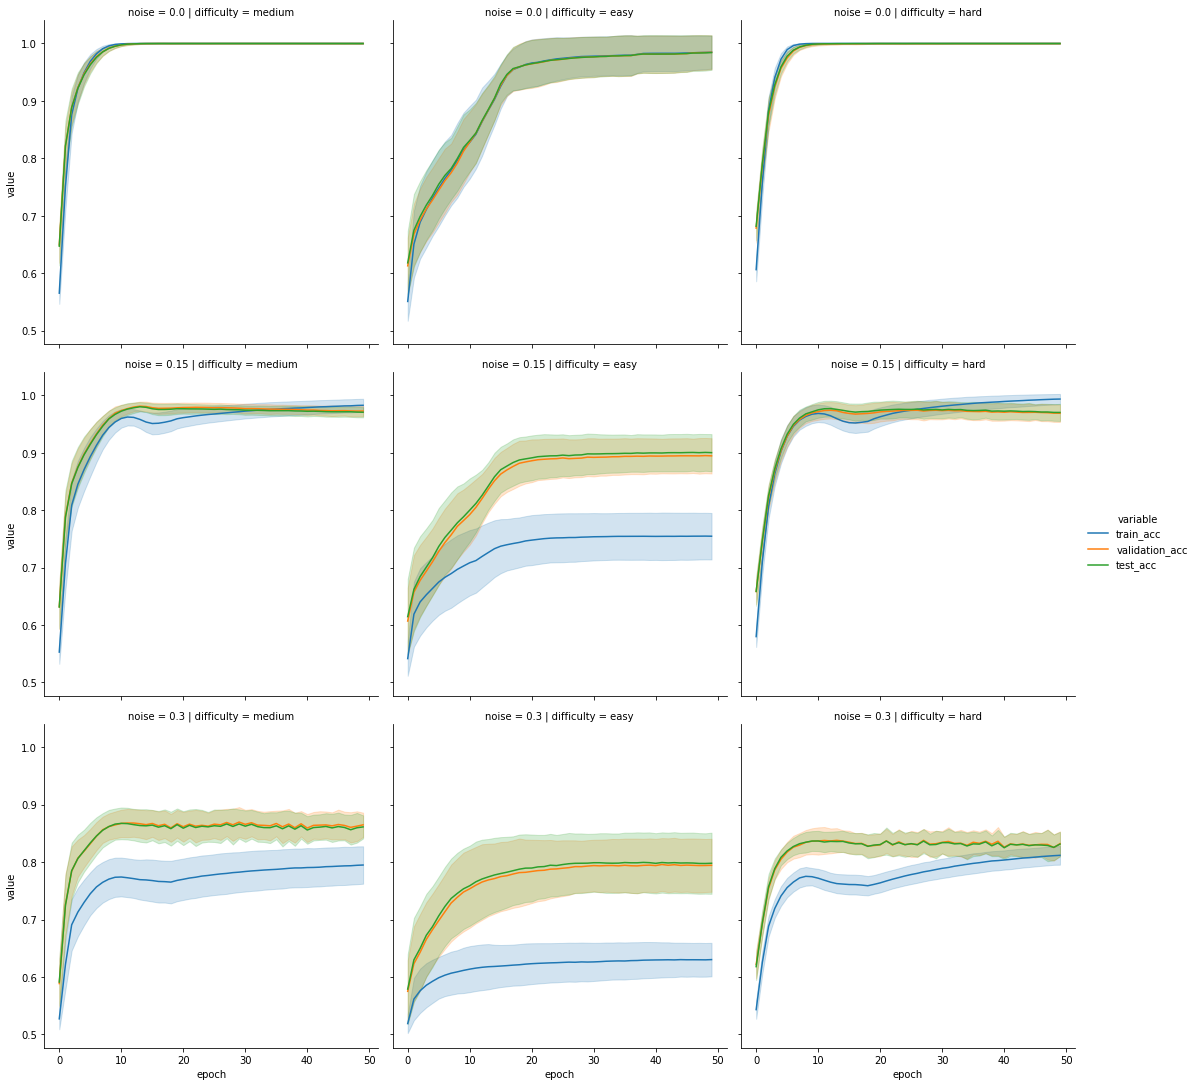

In [6]:
# Let's look at the training curves
# Plot trainint and test results
fields = [k for k in exp_data.columns if k.endswith('acc')]
melt_data = exp_data.melt(id_vars=['epoch', 'difficulty', 'noise'], value_vars=fields)
g = sns.relplot(x='epoch', y='value', hue='variable', kind='line', col='difficulty', row='noise', ci='sd', data=melt_data)
g.savefig('plots/gendnf_training_curves.pdf')

In [7]:
# For our differentiable rule learning, we have X runs per rule
# and there are R many rules (one for each seed) for each difficulty giving X*R*D many runs
run_metadata = exp_data[['run_id', 'difficulty', 'noise', 'seed', 'run_count']]
run_metadata = run_metadata.drop_duplicates().set_index('run_id')
assert run_metadata.index.is_unique, f"Non-unique run ids in metadata {run_metadata.index}"
run_times = exp_data.groupby(['run_id'])['time'].sum()
run_metadata = run_metadata.join(run_times)
run_metadata

,difficulty,noise,seed,run_count,time
run_id,,,,,
aaf335f72a084bfe9a0dcc0ae5cac774,medium,0.15,21,1,135.127505
2a396b543f994e369f131809ae31ba4f,medium,0.30,32,4,136.944865
8bf0e87da5464ab49e5d47102e5aa93c,easy,0.00,3,2,122.833722
47287538fd024e1d83ec374a20c4a1d0,hard,0.15,16,1,144.898714
100f279d754a452b858097dbc37e778b,medium,0.15,16,3,135.580034
...,...,...,...,...,...
6ad4d0be63424e64a432e3c74966402d,hard,0.00,30,3,123.170837
7b213ca2c5834160ab47c21c2e35098d,easy,0.15,27,0,103.080168
dd7ae06d77774335a34a1be762698d66,hard,0.00,5,4,123.231309


In [8]:
# Since symbolic learners go for the optimal result, we will take the best out of 5 runs on each seed
# Take the best point in the run for non-thresholded results and predinet
def take_best_epoch(edata: pd.DataFrame) -> pd.DataFrame:
    """Take the best epoch for each model in the dataframe."""
    # We will take the best validation accuracy as the best point
    best_idxs = edata.groupby(['run_id'])['validation_loss'].idxmin()
    best_data = edata.iloc[best_idxs]
    best_data.set_index('run_id', inplace=True)
    assert best_data.index.is_unique, f"Best data has non-unique run ids: {best_data.index}"
    return best_data[['validation_acc', 'test_acc']]
best_data = take_best_epoch(exp_data)
best_data = best_data.join(run_metadata).assign(model='DNF')
best_data.reset_index(inplace=True)
best_data

,run_id,validation_acc,test_acc,difficulty,noise,seed,run_count,time,model
0,0103f336f48a4eecaa76e65043fcb84f,1.000,1.000,hard,0.00,30,2,131.882503,DNF
1,018ac12159004403b3409a97c5b1dd6d,0.981,0.981,medium,0.15,3,1,138.852384,DNF
2,0236fb7dca51464a93e04196aaaffa35,0.983,0.977,hard,0.15,3,0,152.396837,DNF
3,033d7385c4ae434ab821393bcb573222,0.939,0.958,easy,0.15,32,3,113.104128,DNF
4,03a47051ea6b4c7eb08f005af158a68b,0.966,0.976,hard,0.15,5,2,125.718756,DNF
...,...,...,...,...,...,...,...,...,...
310,fc839285c3cd4b12bb5eb9119d7d10ac,0.868,0.847,hard,0.30,16,4,144.969349,DNF
311,fc9a24ccf6354261b4f573e7fc5a4418,0.878,0.871,medium,0.30,21,2,142.702654,DNF
312,fe317a4534f2421e9e90e39c32cd579f,0.879,0.864,medium,0.30,5,2,152.009953,DNF
313,fead6dfc787d412a9a6e2dcf44c6fe9c,0.795,0.795,easy,0.30,21,2,124.498118,DNF


In [9]:
# We will collect the pruning information which contains the final results for each run
def load_pruning_infos(edata: pd.DataFrame) -> pd.DataFrame:
    """Load pruning information of runs."""
    run_ids = edata['run_id'].unique()
    pruning_infos = list()
    for run_id in tqdm.tqdm(run_ids):
        pruning_json = utils.analysis.load_artifact(run_id, 'pruning_info.json', mlclient)
        pruning_json['run_id'] = run_id
        pruning_infos.append(pruning_json)
    pruning_infos = pd.DataFrame(pruning_infos)
    pruning_infos.set_index('run_id', inplace=True)
    assert pruning_infos.index.is_unique, "Non-unique run ids for pruning info jsons."
    # Filter to useful columns
    # What we are really interested is in the final pruning stage, which is after dnf_layer.and_kernel.xxx_threshold_pruned_xxx
    pruning_infos = pruning_infos[pruning_infos.columns[(pruning_infos.columns.str.startswith('dnf_layer.and_kernel') & pruning_infos.columns.str.endswith('threshold_pruned_acc'))]]
    # Rename for clarity
    col_map = {'dnf_layer.and_kernel.validation_threshold_pruned_acc': 'validation_acc', 'dnf_layer.and_kernel.test_threshold_pruned_acc': 'test_acc'}
    pruning_infos = pruning_infos.rename(columns=col_map)
    return pruning_infos
pruning_data = load_pruning_infos(exp_data)
pruning_data = pruning_data.join(run_metadata).assign(model='DNF+t')
pruning_data.reset_index(inplace=True)
pruning_data

100%|██████████| 315/315 [00:03<00:00, 104.04it/s]


,run_id,validation_acc,test_acc,difficulty,noise,seed,run_count,time,model
0,aaf335f72a084bfe9a0dcc0ae5cac774,0.940,0.946,medium,0.15,21,1,135.127505,DNF+t
1,2a396b543f994e369f131809ae31ba4f,0.812,0.811,medium,0.30,32,4,136.944865,DNF+t
2,8bf0e87da5464ab49e5d47102e5aa93c,1.000,1.000,easy,0.00,3,2,122.833722,DNF+t
3,47287538fd024e1d83ec374a20c4a1d0,0.972,0.970,hard,0.15,16,1,144.898714,DNF+t
4,100f279d754a452b858097dbc37e778b,0.872,0.851,medium,0.15,16,3,135.580034,DNF+t
...,...,...,...,...,...,...,...,...,...
310,6ad4d0be63424e64a432e3c74966402d,1.000,0.999,hard,0.00,30,3,123.170837,DNF+t
311,7b213ca2c5834160ab47c21c2e35098d,0.982,0.986,easy,0.15,27,0,103.080168,DNF+t
312,dd7ae06d77774335a34a1be762698d66,1.000,0.994,hard,0.00,5,4,123.231309,DNF+t
313,4205c38f46af4203842e79178dde8694,0.612,0.591,hard,0.15,27,1,123.216208,DNF+t


In [10]:
# We will collect all task descriptions to analyse what is the average length of the rules
def load_task_descriptions(edata: pd.DataFrame) -> pd.DataFrame:
    """Load pruning information of runs."""
    run_ids = edata['run_id'].unique()
    task_descs = list()
    for run_id in tqdm.tqdm(run_ids):
        task_json = utils.analysis.load_artifact(run_id, 'task_description.json', mlclient)
        and_kernel = np.array(eval(task_json['metadata']['and_kernel'])) # (H, IN)
        or_kernel = np.array(eval(task_json['metadata']['or_kernel'])) # (H,)
        task_desc = {
            'and_size': np.sum((and_kernel*or_kernel[:, None]) != 0),
            'or_size': np.sum(or_kernel),
            'run_id': run_id
        }
        task_descs.append(task_desc)
    task_descs = pd.DataFrame(task_descs)
    task_descs.set_index('run_id', inplace=True)
    assert task_descs.index.is_unique, "Non-unique run ids for pruning info jsons."
    return task_descs
task_data = load_task_descriptions(exp_data)
task_data = task_data.join(run_metadata)
task_data

100%|██████████| 315/315 [00:03<00:00, 102.35it/s]


,and_size,or_size,difficulty,noise,seed,run_count,time
run_id,,,,,,,
aaf335f72a084bfe9a0dcc0ae5cac774,72,2,medium,0.15,21,1,135.127505
2a396b543f994e369f131809ae31ba4f,69,2,medium,0.30,32,4,136.944865
8bf0e87da5464ab49e5d47102e5aa93c,19,3,easy,0.00,3,2,122.833722
47287538fd024e1d83ec374a20c4a1d0,152,3,hard,0.15,16,1,144.898714
100f279d754a452b858097dbc37e778b,76,2,medium,0.15,16,3,135.580034
...,...,...,...,...,...,...,...
6ad4d0be63424e64a432e3c74966402d,146,3,hard,0.00,30,3,123.170837
7b213ca2c5834160ab47c21c2e35098d,18,2,easy,0.15,27,0,103.080168
dd7ae06d77774335a34a1be762698d66,148,3,hard,0.00,5,4,123.231309


In [11]:
# To avoid duplicate counts, filter to only run count 0 and noise 0.0
task_data0 = utils.analysis.filter_by_dict(task_data, {'run_count': 0, 'noise': 0.0})
kernel_size_sums = task_data0.groupby(['difficulty'])[['and_size', 'or_size']].sum()
# Total number of body predicates divided by the total number of rules
(kernel_size_sums['and_size'] / kernel_size_sums['or_size']).round(2)

difficulty
easy       7.29
hard      50.62
medium    37.27
dtype: float64

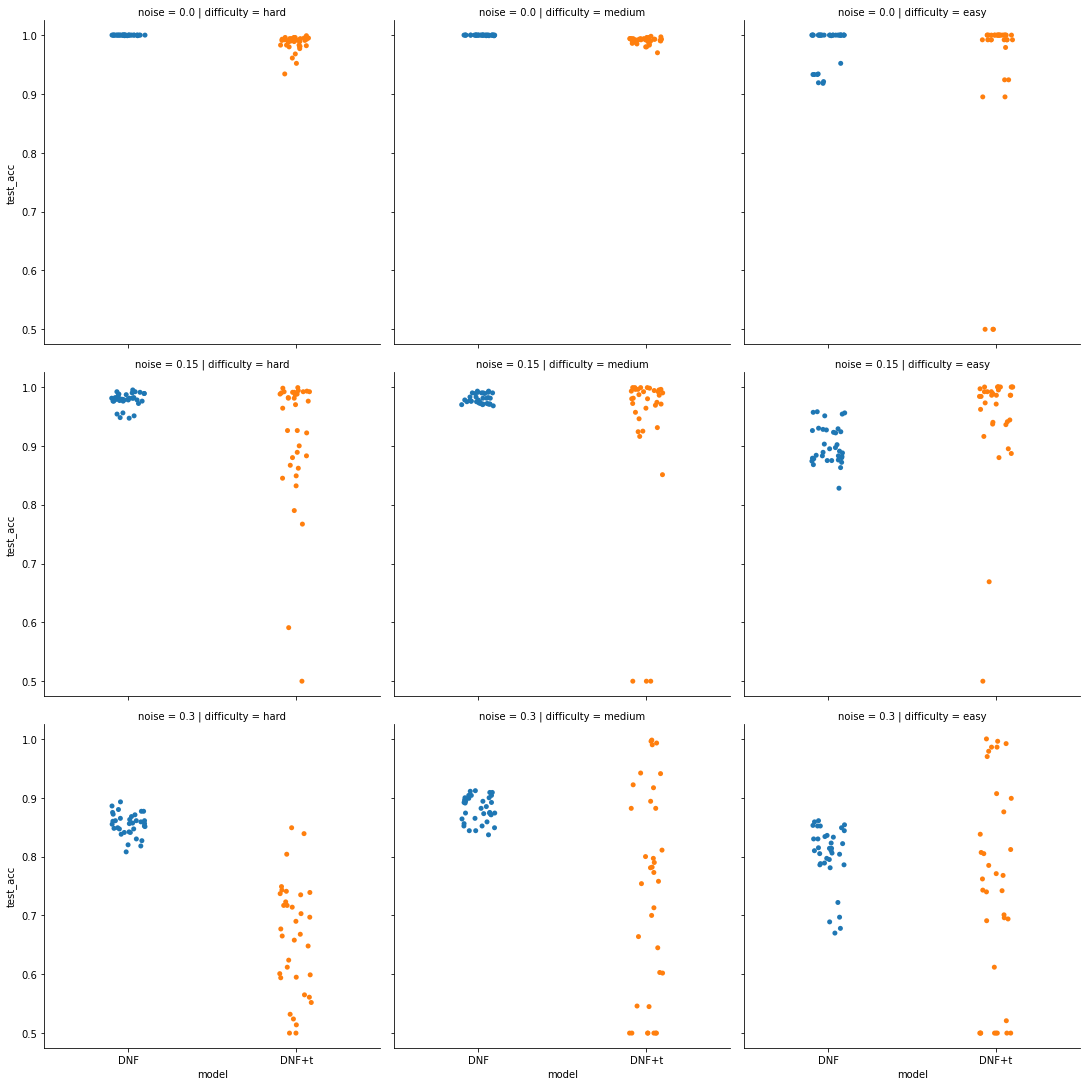

In [12]:
# Here are all the runs, 315 experiments x2 for thresholded results
dnf_data = pd.concat([best_data, pruning_data])
dnf_data.reset_index(drop=True, inplace=True)
#melted_dnf_data = dnf_data.melt(id_vars=['difficulty', 'noise', 'model'], value_vars=['validation_acc', 'test_acc'])
g = sns.catplot(x='model', y='test_acc', col='difficulty', row='noise', kind='strip', data=dnf_data)
g.savefig("plots/all_dnf_data.pdf")

In [13]:
# Since symbolic learners are deterministic and return the optimal result, we will take the best
# out of 5 runs for each rule in each difficulty, but just to ensure that the results are consistent
# let's look at the 5 runs for each rule first
pd.pivot_table(dnf_data, index=['difficulty', 'noise'], columns=['model'], values=['validation_acc', 'test_acc'], aggfunc=['median'])

median                             
                 test_acc        validation_acc       
model                 DNF  DNF+t            DNF  DNF+t
difficulty noise                                      
easy       0.00     1.000  1.000          1.000  1.000
           0.15     0.891  0.986          0.904  0.982
           0.30     0.814  0.762          0.799  0.748
hard       0.00     1.000  0.991          1.000  1.000
           0.15     0.979  0.970          0.979  0.972
           0.30     0.856  0.668          0.862  0.661
medium     0.00     1.000  0.992          1.000  1.000
           0.15     0.978  0.981          0.981  0.985
           0.30     0.882  0.773          0.883  0.753

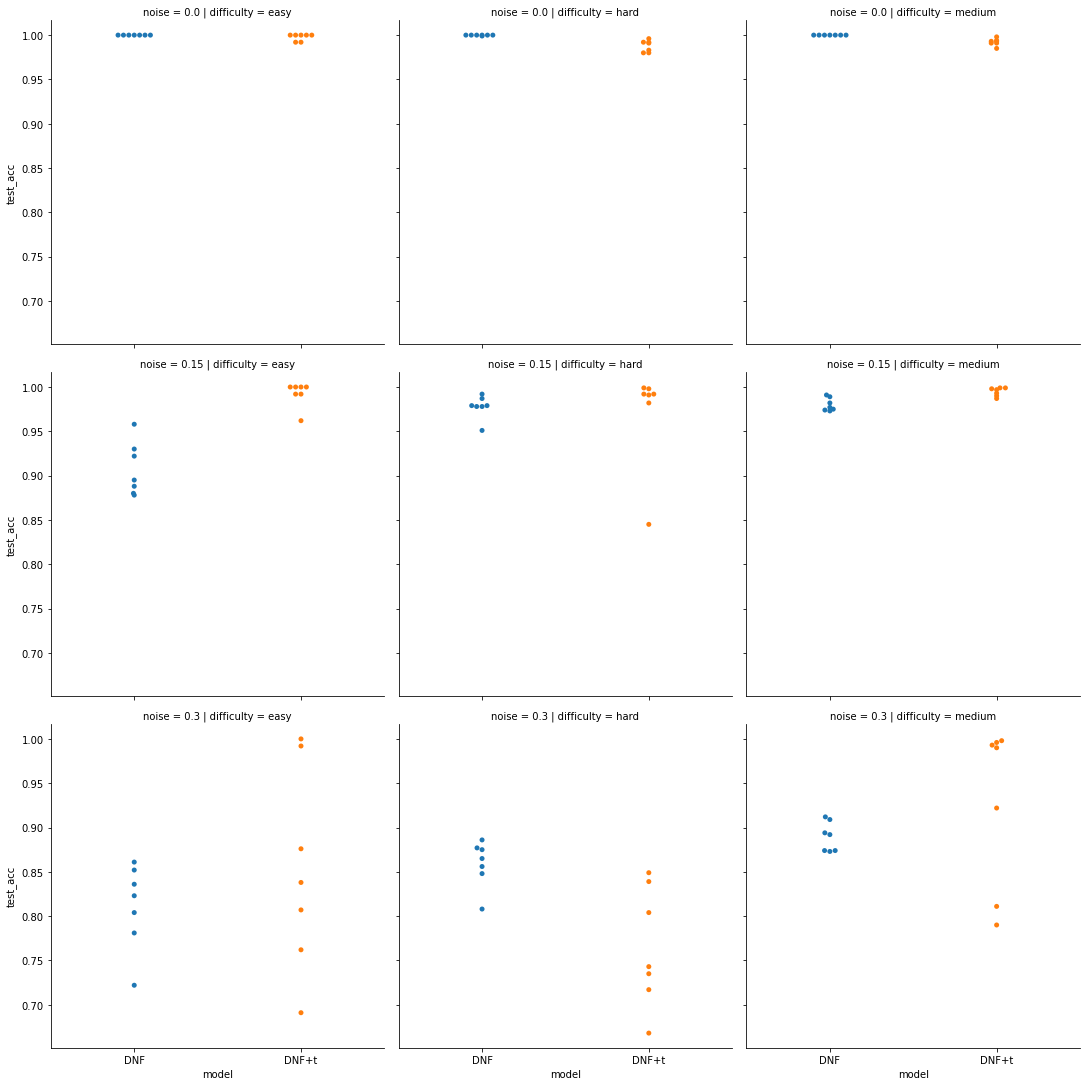

In [14]:
# Now to take the best run for each data configuration
best_dnf = dnf_data.groupby(['model', 'difficulty', 'noise', 'seed'])['validation_acc'].idxmax()
best_dnf = dnf_data.iloc[best_dnf]
g = sns.catplot(x='model', y='test_acc', col='difficulty', row='noise', kind='swarm', data=best_dnf)
g.savefig("plots/best_dnf.pdf")

In [15]:
# And in table form
pd.pivot_table(best_dnf, index=['difficulty', 'noise'], columns=['model'], values=['validation_acc', 'test_acc'], aggfunc=['median', 'mad']).round(3)

median                                   mad         \
                 test_acc        validation_acc        test_acc          
model                 DNF  DNF+t            DNF  DNF+t      DNF  DNF+t   
difficulty noise                                                         
easy       0.00     1.000  1.000          1.000  1.000    0.000  0.003   
           0.15     0.895  1.000          0.909  1.000    0.025  0.009   
           0.30     0.823  0.838          0.809  0.827    0.036  0.089   
hard       0.00     1.000  0.991          1.000  1.000    0.000  0.006   
           0.15     0.979  0.992          0.981  0.995    0.008  0.036   
           0.30     0.865  0.743          0.877  0.769    0.019  0.056   
medium     0.00     1.000  0.993          1.000  1.000    0.000  0.003   
           0.15     0.977  0.997          0.983  1.000    0.006  0.004   
           0.30     0.892  0.990          0.902  0.997    0.014  0.075   

                                        
                 validation_acc         
model                       DNF  DNF+t  
difficulty noise                        
easy       0.00           0.000  0.002  
           0.15           0.022  0.010  
           0.30           0.030  0.085  
hard       0.00           0.000  0.000  
           0.15           0.008  0.034  
           0.30           0.012  0.044  
medium     0.00           0.000  0.000  
           0.15           0.005  0.002  
           0.30           0.017  0.074

In [16]:
# Collect the ILP comparison
ilp_exp_name = "gendnf-ilp-20210503-164950"
ilpexp = mlclient.get_experiment_by_name(ilp_exp_name)
print(ilpexp)
ilp_data =  utils.analysis.collect_experiment_data(ilp_exp_name, mlclient)
ilp_data.reset_index(drop=True, inplace=True)
assert ilp_data.index.is_unique, "Non-unique run ids for ILP data."
fields = ['time', 'train_acc', 'validation_acc', 'test_acc', 'train_type', 'gendnf_difficulty', 'gendnf_rng_seed', 'run_id']
ilp_data = ilp_data[fields]
ilp_data.rename(columns={'train_type': 'model', 'gendnf_difficulty': 'difficulty', 'gendnf_rng_seed': 'seed'}, inplace=True)
ilp_data

 43%|████▎     | 6/14 [00:00<00:00, 58.91it/s]

<Experiment: artifact_location='/homes/nuric/phd/pix2rule/data/artifacts/46', experiment_id='46', lifecycle_stage='active', name='gendnf-ilp-20210503-164950', tags={}>


100%|██████████| 14/14 [00:00<00:00, 58.83it/s]


,time,train_acc,validation_acc,test_acc,model,difficulty,seed,run_id
0,29.002833,1.0,1.0,1.0,fastlas,easy,5,6a2dbedfe51e4c39a3ec6520fd108834
1,30.571854,1.0,1.0,1.0,fastlas,easy,21,abb4912c1fb2461e8e310e917e20e4b3
2,3516.000000,1.0,1.0,1.0,ilasp,easy,5,4d8a15edcc814989a8ad337fd27764f7
3,2279.000000,1.0,1.0,1.0,ilasp,easy,30,34b38f1afbb7448d9d7e12a2e71220c4
4,29.846843,1.0,1.0,1.0,fastlas,easy,30,776e1079ecf048b9b7f52ca035666f28
5,28.533741,1.0,1.0,1.0,fastlas,easy,16,d7f39522a27548d98a038e21e7f0ded4
6,1761.000000,1.0,1.0,1.0,ilasp,easy,32,6d528d5669844fdcb60b4a2ea62340e4
7,3701.000000,1.0,1.0,1.0,ilasp,easy,3,be9acd736a5b4f05b77c22b04c199be5
8,3336.000000,1.0,1.0,1.0,ilasp,easy,27,66504e228078443fb70928c09bd6d821
9,4467.000000,1.0,1.0,1.0,ilasp,easy,21,abd9b25e77ca42f38aa1a23c30cd3811


In [17]:
# Concatenate the data, note that ILP is only run without noise
ilp_dnf_data = pd.concat([ilp_data, best_dnf[best_dnf['noise'] == 0.0]])
ilp_dnf_data.reset_index(drop=True, inplace=True)
pd.pivot_table(ilp_dnf_data, index=['model'], columns=['difficulty'], values=['test_acc', 'time'], aggfunc=['median', 'mad']).round(2)

median                                            mad        \
           test_acc                  time                 test_acc         
difficulty     easy  hard medium     easy    hard  medium     easy  hard   
model                                                                      
DNF             1.0  1.00   1.00   127.13  129.56  136.90      0.0  0.00   
DNF+t           1.0  0.99   0.99   125.02  143.67  135.67      0.0  0.01   
fastlas         1.0   NaN    NaN    29.85     NaN     NaN      0.0   NaN   
ilasp           1.0   NaN    NaN  3336.00     NaN     NaN      0.0   NaN   

                                         
                     time                
difficulty medium    easy   hard medium  
model                                    
DNF           0.0    4.17   5.77  10.00  
DNF+t         0.0    6.53  22.60   8.56  
fastlas       NaN    0.69    NaN    NaN  
ilasp         NaN  994.45    NaN    NaN

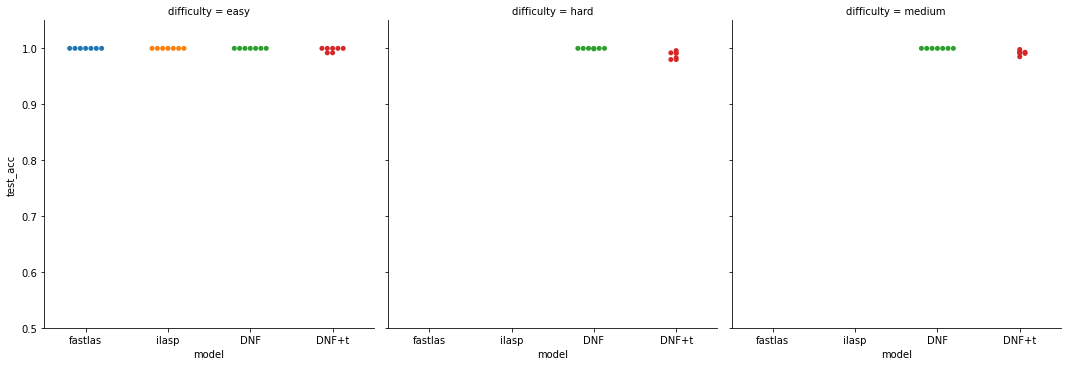

In [18]:
# Also as a plot
g = sns.catplot(x='model', y='test_acc', kind='swarm', col='difficulty', data=ilp_dnf_data)
plt.ylim(0.5, 1.05)
g.savefig('plots/gendnf_ilp_vs_deep.pdf')

## Analyse Run Report
We can pick a single run and analyse the reports such as attention maps and the rules it has learned.

- Look at learnt kernels, prepruning, after pruning and thresholded
- Show the final learnt rule

In [19]:
# For each difficulty pick a random run to analyse
filter_dict = {'difficulty': 'easy', 'noise': 0.0}
run_ids = utils.analysis.filter_by_dict(best_dnf, filter_dict)['run_id'].unique()
run_ids

array(['8bf0e87da5464ab49e5d47102e5aa93c', '1c33dd0d979045a38d5b4d4314764357', '1b8c33c464d343b699d40d52cd3f780c',
       '13c860b7c68f495fab36f18024a94106', '1fa9da6595d0440eb72638543f15074a', '3ccd3ae87476484681f75bbf139efec6',
       '4299e3554e394a8db1ee3d23707f8c48', 'f9d0d167c52c42bc8a42bcf66edf9a56', '8d2a766aee8e4bc69e8759a310b6f51e',
       '79fab45361344716b904024bf27ddc0c', '2caeb3890d3b4174b082da0f2def1bf1', 'a1fceb475f894ba4b00cbf299755c262'],
      dtype=object)

In [20]:
# Gather a specific run
run_id = "8bf0e87da5464ab49e5d47102e5aa93c"
print("Collecting artifacts for run:", run_id)
mlrun = mlclient.get_run(run_id)
pprint(mlrun.to_dictionary())
pprint(mlclient.list_artifacts(run_id))

{'data': {'metrics': {'epoch': 49.0,
                      'test_acc': 1.0,
                      'test_loss': 0.018160270527005196,
                      'time': 3.0774970054626465,
                      'train_acc': 1.0,
                      'train_dnf_layer/success_threshold': 1.0,
                      'train_loss': 0.0198676697909832,
                      'validation_acc': 1.0,
                      'validation_loss': 0.018837902694940567},
          'params': {'config_json': 'data/experiments.json.24af0c86e18aeb08a241f08db230a0bc',
                     'data_dir': 'data',
                     'dataset_name': 'gendnf',
                     'debug': 'False',
                     'dnf_image_classifier_hidden_arities': '[0]',
                     'dnf_image_classifier_hidden_layer_name': 'WeightedDNF',
                     'dnf_image_classifier_hidden_num_conjuncts': '8',
                     'dnf_image_classifier_hidden_num_total_variables': '2',
                     'dnf_image_cl

In [21]:
# Here is the model summary
print(utils.analysis.load_artifact(run_id, "model_summary.txt", mlclient))

Model: "dnf_rule_learner"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nullary (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
unary (InputLayer)              [(None, 3, 2)]       0                                            
__________________________________________________________________________________________________
binary (InputLayer)             [(None, 3, 2, 2)]    0                                            
__________________________________________________________________________________________________
merge_facts (MergeFacts)        {'nullary': (None, 2 0           nullary[0][0]                    
                                                                 unary[0][0]       

In [22]:
# What was the task?
task_description = utils.analysis.load_artifact(run_id, 'task_description.json', mlclient)
print("Target kernels:")
pprint(task_description['metadata']['and_kernel'])
pprint(task_description['metadata']['or_kernel'])
print("Target rule:")
task_description['metadata']['rule_str']

Target kernels:
('[[1, -1, -1, -1, -1, 1, 1, 0, -1, -1], [-1, 0, 0, 0, -1, -1, 1, 1, -1, -1], '
 '[0, 0, 1, 0, 0, 0, 0, 0, -1, 1]]')
'[1, 1, 1]'
Target rule:


['t :- nullary(0), not nullary(1), not unary(V0,0), not unary(V0,1), not unary(V1,0), unary(V1,1), binary(V0,V1,0), not binary(V1,V0,0), not binary(V1,V0,1), obj(V0), V0 != V1, obj(V1).',
 't :- not nullary(0), not unary(V1,0), not unary(V1,1), binary(V0,V1,0), binary(V0,V1,1), not binary(V1,V0,0), not binary(V1,V0,1), obj(V0), V0 != V1, obj(V1).',
 't :- unary(V0,0), not binary(V1,V0,0), binary(V1,V0,1), obj(V0), V0 != V1, obj(V1).']

In [23]:
# What did the model learn?
pruning_info = utils.analysis.load_artifact(run_id, 'pruning_info.json', mlclient)
for key in ['preprune', 'pruned', 'threshold_pruned']:
    print(key.upper())
    print(np.array(pruning_info["dnf_layer.or_kernel."+key]))
    print(np.array(pruning_info["dnf_layer.and_kernel."+key]))

PREPRUNE
[[4.76378 4.64197 4.18987]]
[[[ 0.00888 -0.0691   2.16163  0.00052 -0.06284 -0.06364  0.00014 -0.00012 -2.26675  2.2251 ]
  [-1.60833  0.01677 -1.84081 -1.85175  0.03175  0.05595 -1.85182 -1.75742  1.85248  1.85215]
  [ 0.98037 -0.98281 -0.62498 -0.75279 -0.8174   0.82711  0.80453  0.03989 -0.97034 -0.66585]]]
PRUNED
[[4.76378 4.64197 4.18987]]
[[[ 0.      -0.       2.16163  0.      -0.      -0.       0.      -0.      -2.26675  2.2251 ]
  [-1.60833  0.      -1.84081 -1.85175  0.       0.      -1.85182 -1.75742  1.85248  1.85215]
  [ 0.98037 -0.98281 -0.62498 -0.75279 -0.8174   0.82711  0.80453  0.      -0.97034 -0.66585]]]
THRESHOLD_PRUNED
[[6. 6. 6.]]
[[[ 0.  0.  6.  0.  0.  0.  0.  0. -6.  6.]
  [-6.  0. -6. -6.  0.  0. -6. -6.  6.  6.]
  [ 6. -6. -6. -6. -6.  6.  6.  0. -6. -6.]]]


In [24]:
# What is the final rule?
print("Final test accuracy with following rule is", pruning_info['dnf_layer.and_kernel.test_threshold_pruned_acc'])
test_report = utils.analysis.load_artifact(run_id, 'test_report.npz', mlclient)
# Here we construct an interpretation to get the size of the domain, it is not used in translating the actual rule
interpretation = {k: test_report['in_'+k] for k in ['nullary', 'unary', 'binary']}
rule_kernels = {
    'and_kernel': np.array(pruning_info['dnf_layer.and_kernel.threshold_pruned'])[0]/6,
    'or_kernel': np.array(pruning_info['dnf_layer.or_kernel.threshold_pruned'])[0]/6,
    'num_variables': task_description['metadata']['num_variables']
}
learnt_rules = utils.clingo.tensor_rule_to_strings(interpretation, rule_kernels)
learnt_rules

Final test accuracy with following rule is 1.0


['t :- unary(V0,0), not binary(V1,V0,0), binary(V1,V0,1), obj(V0), V0 != V1, obj(V1).',
 't :- not nullary(0), not unary(V0,0), not unary(V0,1), not binary(V0,V1,0), not binary(V0,V1,1), binary(V1,V0,0), binary(V1,V0,1), obj(V0), V0 != V1, obj(V1).',
 't :- nullary(0), not nullary(1), not unary(V0,0), not unary(V0,1), not unary(V1,0), unary(V1,1), binary(V0,V1,0), not binary(V1,V0,0), not binary(V1,V0,1), obj(V0), V0 != V1, obj(V1).']

In [25]:
# Sanity check with clingo, this is just a single batch check, the training script does the full version
results = utils.clingo.clingo_rule_check(interpretation, learnt_rules)
(results == (test_report['out_label'] == 1)).mean()

100%|██████████| 128/128 [00:02<00:00, 56.85it/s]


1.0

In [26]:
{k: v for k, v in pruning_info.items() if 'acc' in k}

{'dnf_layer.or_kernel.validation_preprune_acc': 1.0,
 'dnf_layer.or_kernel.test_preprune_acc': 1.0,
 'dnf_layer.or_kernel.validation_pruned_acc': 1.0,
 'dnf_layer.or_kernel.test_pruned_acc': 1.0,
 'dnf_layer.or_kernel.validation_threshold_acc': 1.0,
 'dnf_layer.or_kernel.test_threshold_acc': 1.0,
 'dnf_layer.or_kernel.validation_threshold_pruned_acc': 1.0,
 'dnf_layer.or_kernel.test_threshold_pruned_acc': 1.0,
 'dnf_layer.and_kernel.validation_preprune_acc': 1.0,
 'dnf_layer.and_kernel.test_preprune_acc': 1.0,
 'dnf_layer.and_kernel.validation_pruned_acc': 1.0,
 'dnf_layer.and_kernel.test_pruned_acc': 1.0,
 'dnf_layer.and_kernel.validation_threshold_acc': 1.0,
 'dnf_layer.and_kernel.test_threshold_acc': 1.0,
 'dnf_layer.and_kernel.validation_threshold_pruned_acc': 1.0,
 'dnf_layer.and_kernel.test_threshold_pruned_acc': 1.0}